In [1]:
# Imports

from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionContext, ExecutionMode, Executor
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import append_configs
from cadCAD import configs
import pandas as pd
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from IPython.display import display
from contracts import *

In [2]:
# The system's initial states for the A/B test.

initial_state = {
    "vat": Vat(),
    "vow": Vow(),
    "flipper": Flipper(),   
    "flopper": Flopper(),   
    "flapper": Flapper()   
}

In [3]:
# Policy functions defining how much the state update functions should change the variables. (More modular than encoding agent behavior/logic in state update functions)

robot_probs = [1/2, 1/3]

# Add marble to Box A if it has fewer marbles, and vice versa.
def robot_arm(params, step, sL, s, capacity):
    incr_A = 0
    if s["box_A"] < s["box_B"]:
        incr_A = capacity
    elif s["box_A"] > s["box_B"]:
        incr_A = -capacity
    incr_B = -incr_A
    
    return { "incr_A": incr_A, "incr_B": incr_B }

def robot_policy(robot_idx):
    def random_execute(params, step, sL, s):
        capacity = params["capacity"][robot_idx]
        probability = robot_probs[robot_idx]
        if rand() < probability:
            return robot_arm(params, step, sL, s, capacity)
        return { "incr_A": 0, "incr_B": 0 }
    
    return random_execute


In [4]:
# The state transition functions ("mechanisms" in cadCAD) for the state variables.

def update_A(params, step, sL, s, _input):
    return ("box_A", s["box_A"] + _input["incr_A"])

def update_B(params, step, sL, s, _input):
    return ("box_B", s["box_B"] + _input["incr_B"])


In [5]:
# "Partial state update blocks", each dict in the list represents one execution block within which the state update functions run in parallel (blocks are run serially).

PSUBs = [{
    "policies": {   # Policies (define _input)
        "robot_policy_0": initial_state["vat"],
        "robot_policy_1": robot_policy(1)
    },
    "variables": {  # State variable update functions
        "box_A": update_A,
        "box_B": update_B
    }
}]

In [6]:
# Configuration parameters for the simulation.

params = config_sim({
    "T": range(20), # Number of timesteps
    "N": 50, # Number of Monte Carlo runs
    "M": {
        "capacity": [[1, 1], [2, 1], [2, 2]]
    }
})

In [7]:
# cadCAD Configuration object setup.

append_configs(sim_configs=params, initial_state=initial_state, partial_state_update_blocks=PSUBs)

[{'N': 50, 'T': range(0, 20), 'M': {'capacity': [1, 1]}}, {'N': 50, 'T': range(0, 20), 'M': {'capacity': [2, 1]}}, {'N': 50, 'T': range(0, 20), 'M': {'capacity': [2, 2]}}]
[{'N': 50, 'T': range(0, 20), 'M': {'capacity': [1, 1]}}, {'N': 50, 'T': range(0, 20), 'M': {'capacity': [2, 1]}}, {'N': 50, 'T': range(0, 20), 'M': {'capacity': [2, 2]}}]
[{'N': 50, 'T': range(0, 20), 'M': {'capacity': [1, 1]}}, {'N': 50, 'T': range(0, 20), 'M': {'capacity': [2, 1]}}, {'N': 50, 'T': range(0, 20), 'M': {'capacity': [2, 2]}}]


In [8]:
# Executing the simulation.

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, configs)

results = []
for raw_result, tensor in executor.execute():
    df = pd.DataFrame(raw_result)
    results.append(df)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x113e19160>, <cadCAD.configuration.Configuration object at 0x113e19390>, <cadCAD.configuration.Configuration object at 0x113e194e0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x113e19160>, <cadCAD.configuration.Configuration object at 0x113e19390>, <cadCAD.configuration.Configuration object at 0x113e194e0>]


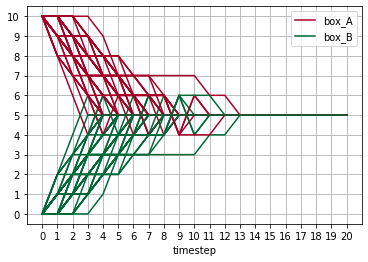

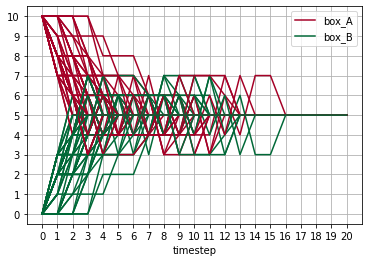

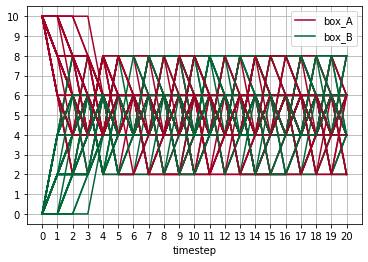

In [9]:
# Analyzing the simulation results.

def print_plot(N):
    ax = None
    for i in range(N):
        ax = df[df['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                         grid=True,
                                         xticks=list(df['timestep'].drop_duplicates()), 
                                         yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                         legend = (ax == None),
                                         colormap = 'RdYlGn',
                                         ax = ax
                                      )

for df in results:
    print_plot(params[0]['N'])